In [5]:
#@title Import All Needed Modules
'''!pip install plotly.express
!pip install plotly-geo==1.0.0
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3'''
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go 
import pandas as pd
from plotly.subplots import make_subplots
from sklearn.preprocessing import OrdinalEncoder
from io import StringIO
from wordcloud import STOPWORDS
from wordcloud import WordCloud
import PIL.Image as Image
%matplotlib inline

#Our Group Project's Basic Introduction


---


###Background
As the 21st Century continues, police abuse of violence has gradually become an increasingly serious and controversial social problem in the United States. According to official statistics, about 100 police officers have been charged with homicide for using deadly force since 2005. Under the shadow of several influential current social incidents, the common stereotypes of 'deadly police violence' in the US appear to be solidly set.


---



###Analytical Goal

How much of these stereotypes of American domestic law enforcement departments are real? Is US police violence truly unsettling fatal and biased as widely and commonly believed? In this project, we are aiming to discover and reflect the reality with our efforts.

We will use data sources regarding police-related fatalities in the United States, derived from several different sources,including US Department of Justice, Mapping Police Violence.org, multiple American local police departments, which has been stored into '*police_killings_MPV.csv*' , to explore the current state of police fatalities in the United States and related patterns in multiple dimensions. We hope that our research and visualization of this dataset will serve as an objective source for thoughtful, fact-based reflection and analysis of this controversial issue.

In [6]:
#@title Import and Analysis the dataset#
# Load the 'police_killing' dataset from ***
df = pd.read_csv('police_killings_MPV.csv',encoding='ISO-8859-1')
df['Year']=(df['Date of Incident (month/day/year)'].str[6:10])
df['Weapon']=df['Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)']
df['Geography']=df['Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )']
df['Description']=df['A brief description of the circumstances surrounding the death']
# Understand the basic information of dataset and the data types involved
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8427 entries, 0 to 8426
Data columns (total 23 columns):
 #   Column                                                                                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                                                                                      --------------  -----  
 0   Victim's age                                                                                                                                                                8427 non-null   object 
 1   Victim's gender                                                                                                                                                             8415 non-null   object 
 2   Victim's race                                                                       

#####Analytical Conclusion:
 - This whole dataset contains 23 different columns and 8427 rows of detailed information in total. In other words, totally **23 different dimensions** of **8427 deaths** are recorded.
 - From **incident's basic properties' perspective**, this dataset contains 11 different aspects,including date of incident\city\state\zipcode\county\cause of death\geography\year\description\brief description. 
 - From **victim's perspective**, this dataset contains 8 different aspects, including age\race\gender\symptoms or mental illness\alleged weapon held\alleged threat level\fleeing or not.
 - From **police departments' perspective**, this dataset contains 4 different aspects, including agency responsible for death\off-duty-killing\criminal charges\official disposition.



##1.General Summary of Police Fatalities
In this section, we will present the summarial statistics of police fatalities recorded in this dataset, including counts by year, and visualization of cause of death.

In [7]:
#@title 1-1 Police Fatalities Counts by Year
dfyear = df.groupby('Year')["Year"].count().to_frame()
figyear=go.Figure(data=[go.Bar(x=dfyear.index, y=dfyear['Year'],text=dfyear['Year'],marker_color='rgb(252,146,137)')])
figyear.update_yaxes(range=[0,1250])
figyear.update_layout(title = "Police Fatalities Counts by Year")
figyear.show()

#####Analytical Conclusion:
 - Each year's figure presented an almost identical result of around 1100 deaths per year. 2020's figure is relatively low because this dataset's record reaches no further than Sept 2020.
 - Conclusion can be drawn that police fatalities are staying in a relatively stable situation, without any sign of sudden big changes.

In [8]:
#@title 1-2 Bar Chart of Cause of Death
str = ', '
causedeath = str.join(df['Cause of death']).split(", ")
causelist=[]
countlist=[]
for n in causedeath:
    cause=n
    count=causedeath.count(cause)
    
    causelist.append(cause)
    countlist.append(count)

causedeathdata={'Cause of Death':causelist,"Count":countlist}
causedeathdataframe=pd.DataFrame(causedeathdata,columns=['Cause of Death','Count']).sort_values('Count',ascending=False).drop_duplicates()

bardeath = go.Figure(data=[go.Bar(y=causedeathdataframe['Cause of Death'],x=causedeathdataframe["Count"],
                                    text=causedeathdataframe['Count'],orientation='h')])
bardeath.update_layout(title = 'Numbers of Cause of Death',yaxis={'categoryorder':'total ascending'})
bardeath.update_xaxes(type="log")
bardeath.show()

#####Analytical Conclusion:
 - Gun shootings account for the vast majority of deaths.
 - It is easy to draw the conclusion that firearms and stun guns are the weapons most commonly used by American police in law enforcement.



##2.Discoveries of Police Fatalities' Patterns
In this section, we will try to find out whether police fatalities are regional , whether there are certain police departments that are relatively involved in more police fatalities, and analyze whether there is a high probability of manslaughter.

In [9]:
#@title 2-1 The Number  cases by State in USA

pd_map_state = df.groupby('State')['City'].count().sort_values(ascending=False).to_frame().reset_index()
pd_map_state = pd_map_state.rename(columns={'City':'Numbers'})

fig = go.Figure(data=go.Choropleth(
    locations=pd_map_state['State'], # Spatial coordinates
    z = pd_map_state['Numbers'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Cases",
))

fig.update_layout(
    title_text = 'The Number  cases by State in USA',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

#####Analytical Conclusion:
 - The number of cases  shows a trend of less in the north and more in the south, and the number is mainly concentrated in California and Texas.
 - California leads nation in number of cases 

In [10]:
#@title 2-2 Top 10 police departments with the most fatalities
dd_count = df.groupby(by='Agency responsible for death')['Zipcode'].count().sort_values(ascending=False).to_frame().reset_index()
names = ["Agency","Count"]
dd_count.columns = names
agency = dd_count.head(11)

fig = px.bar(agency, x='Agency', y='Count',
             hover_data=['Agency', 'Count'], color='Agency',
             height=600 , title="Top 10 police departments with the most fatalities")
fig.show()

#####Analytical Conclusion:
 - Classify the police stations in the original data, and calculate the sum of the number of casualties in each police station to see the distribution of fatalities in all police stations.
 - The picture shows the top ten police stations with the highest number of fatalities of all police departments, and the police station with the highest number of police deaths is the Los Angeles Police Department (131 deaths)
 - However, the number of fatalities does not prove whether a police department has made mistakes, so further filtering of the data is needed to see the distribution of manslaughter deaths.

###2-3 Police manslaughter rate
After analysis the dataset's detailed information, we decide to define the police manslaughter rate, in order to fetch better explained statistics on police misconduct.

We selected all fatalities which are suitable for following conditions: not holding weapons, sober, and threat level equals 'other', as manslaughter samples.

In [11]:
ob = df[df['Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)']=='no object']
ob1 = ob[ob['Symptoms of mental illness?']=='No']
ob2 = ob1[ob1['Alleged Threat Level (Source: WaPo)']=='other'].reset_index()
display(ob2.set_index(ob2.index+1))

print("The number of all fatalities by police:",df["Victim's age"].count())
print("The number of police manslaughters:",ob2["Victim\'s gender"].count())
print("Police manslaughter rate",'percent: {:.2%}'.format(ob2["Victim\'s gender"].count()/df["Victim's age"].count()))

,index,Victim's age,Victim's gender,Victim's race,Date of Incident (month/day/year),City,Agency responsible for death,State,Zipcode,County,...,Symptoms of mental illness?,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo),Fleeing,Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),Year,Weapon,Geography,Description
1,232,25,Female,White,13/06/2020,Sedalia,Pettis County Sheriff's Office,MO,65301.0,Pettis,...,No,no object,other,Not fleeing,NaN,Suburban,2020,no object,Suburban,"Around 10 p.m., a deputy pulled over a woman d..."
2,282,22,Female,White,28/05/2020,Columbus,Columbus Police Department,OH,43215.0,Franklin,...,No,no object,other,NaN,NaN,Urban,2020,no object,Urban,Sarah Grossman was reportedly tear gassed duri...
3,303,46,Male,Black,25/05/2020,Minneapolis,Minneapolis Police Department,MN,55407.0,Hennepin,...,No,no object,other,NaN,NaN,Urban,2020,no object,Urban,Police responded to a call from a grocery stor...
4,311,28,Male,Black,23/05/2020,Bass River,New Jersey State Police,NJ,8087.0,Burlington,...,No,no object,other,Not fleeing,NaN,Suburban,2020,no object,Suburban,Maurice S. Gordon was shot and killed by a sta...
5,345,25,Male,White,12/05/2020,Plainedge,New York Police Department,NY,11735.0,Nassau,...,No,no object,other,NaN,Off-duty,Suburban,2020,no object,Suburban,A fight broke out on a wooded path involving f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,6171,35,Male,Hispanic,13/02/2015,Reading,Pennsylvania State Police Department,PA,19606.0,Berks,...,No,no object,other,Not fleeing,NaN,Suburban,2015,no object,Suburban,Shot by state police officer who was assisting...
150,6209,42,Male,White,29/01/2015,Stillwater,Stillwater Police Department,OK,74075.0,Payne,...,No,no object,other,Foot,NaN,Suburban,2015,no object,Suburban,Authorities responded to a fire at an apartmen...
151,6219,24,Male,Hispanic,26/01/2015,Tahoka,Lynn County Sheriff's Office,TX,79373.0,Lynn,...,No,no object,other,Car,NaN,Rural,2015,no object,Rural,The subject was arrested after leading officer...
152,6284,23,Male,Hispanic,03/01/2015,Wichita,Wichita Police Department,KS,67208.0,Sedgwick,...,No,no object,other,Not fleeing,NaN,Urban,2015,no object,Urban,The 23-year-old was shot twice by a Wichita po...


The number of all fatalities by police: 8427
The number of police manslaughters: 153
Police manslaughter rate percent: 1.82%


#####Analytical Conclusion:
 - After sifting through the data, we learned that the number of police manslaughters was 153, and the number of deaths in the whole year was 8427, which showed that the police manslaughter rate was round 1.82%.

In [12]:
#@title 2-4 Top 5 police departments with the most manslaughter
ob = df[df['Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)']=='no object']
ob1 = ob[ob['Symptoms of mental illness?']=='No']
ob2 = ob1[ob1['Alleged Threat Level (Source: WaPo)']=='other']

dm_count = ob2.groupby(by='Agency responsible for death')['Zipcode'].count().sort_values(ascending=False).to_frame().reset_index()
names = ["Agency","Count"]
dm_count.columns = names
magency = dm_count.head(5)

fig = px.bar(magency, x='Agency', y='Count',
             hover_data=['Agency', 'Count'], color='Agency',
             height=600 , title="Top 10 police departments with the most manslaughter")
fig.show()

#####Analytical Conclusion:
 - We again classify the data of manslaughter by police station and calculate the number of people to see the distribution of manslaughter by police.
 - As shown in the picture, there are only three police stations with the largest number of police manslaughters, namely Hillsborough County Sheriff's Office, Los Angeles County Sheriff's Department, and Phoenix Police Department.
 - Interestingly, compared with the distribution of the total number of fatalities, the Los Angeles Police Department with the most fatalities did not enter the top 10 in the number of manslaughters. Although the Los Angeles Police Department has the highest number of fatalities, the police error rate is relatively low.

##3.Portraits of victims' General Characteristics
In this section, we will try to present the specific characteristics and portraits of the victims more accurately and extensively, such as age, gender, race, specific behavioral characteristics at the time of the incident, etc., in order to judge whether some characteristics of the victims themselves will be more likely to lead to a relatively higher incidence of police violence.

In [13]:
#@title 3-1 Top 20 Numbers of Alleged Weapon Held by the Deceased
str = ','
weapondeath = str.join(df['Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)']).split(",")
weaponlist=[]
countweapon=[]
for n in weapondeath:
    weapon=n
    count=weapondeath.count(weapon)
    
    weaponlist.append(weapon)
    countweapon.append(count)

weapondata={'Weapon':weaponlist,"Count":countweapon}
weapondataframe=pd.DataFrame(weapondata,columns=['Weapon','Count']).sort_values('Count',ascending=False).drop_duplicates().head(20)

bardeath = go.Figure(data=[go.Bar(y=weapondataframe['Weapon'],x=weapondataframe["Count"],
                                    text=weapondataframe['Count'],orientation='h')])
bardeath.update_layout(title = 'Top 20 Numbers of Alleged Weapon Held by the Deceased',yaxis={'categoryorder':'total ascending'})
bardeath.update_xaxes(type="log")
bardeath.show()

#####Analytical Conclusion:
 - Almost 90% of the victims showed hostility by holding weapons including guns, knifes and other kinds.
 - 883 victims were not holding any weapons, and 252 victims were holding toy weapon, whose intention could be misunderstood.

In [14]:
#@title 3-2 Proportion of Deceased with Escape Intention or Mental Illness
figpie = make_subplots(rows=1,cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]]
                          ,subplot_titles=['Fleeing', 'Mental Illness'])
figpie.add_trace(go.Pie(labels=df['Fleeing'],values=df['Fleeing'].value_counts(),textinfo='label+percent',insidetextorientation='radial'),1,1)
figpie.add_trace(go.Pie(labels=df['Symptoms of mental illness?'],values=df['Symptoms of mental illness?'].value_counts(),textinfo='label+percent',insidetextorientation='radial'),1,2)
figpie.update_layout(title = "Proportion of Deceased with Escape Intention or Mental Illness")
figpie.update_traces(textposition="inside")
figpie.show()

#####Analytical Conclusion:
 - By dividing the behaviors of deceased when facing police's law enforcing actions, from the dimension of fleeing or not, we spot that 96.7% of victims did not take attempts to flee, 3.05% of victims attempted to flee with car, and 0.27% stayed unknown. In conclusion, most of the victims did not take actions to flee.
 - By dividing the mental states of deceased when facing police's law enforcing actions, from the dimension of drug/alcohol usage, we spot that 96.2% of victims were sober, 3.78% of victims were under the effect of mental disturbance. In conclusion, most of the victims were sober at that time.

In a nutshell, most of the victims did not engage in evasive behavior and were in normal states of minds.


In [15]:
#@title 3-3  The age distribution of victims 
df_plot = df.loc[df["Victim's age"] != 'Unknown',["Victim's race", "Victim's age"]]
df_plot = df_plot.apply(pd.to_numeric,errors='ignore')

import plotly.express as px
fig = px.box(df_plot,
        x="Victim's race", 
        y="Victim's age", 
        points="all",
        color="Victim's race",
        title="Age distribution of victims  by ethnicity")
fig.show()


#####Analytical Conclusion:
 - By dividing the age distribution of victims  by the dimension of race, we can find that the median age of the above seven races (including unknown races) is between 30-45 years old.
 - Blacks have the largest age range of victims , ranging from 1 to 107 years old, and the black group has the youngest median age of any race at just 30 years old.


In [23]:
#@title 3-4  The gender distribution of victims 
df_plot = df.loc[df["Victim's age"] != 'Unknown',["Victim's gender", "Victim's age"]]
df_plot = df_plot.apply(pd.to_numeric,errors='ignore')

import plotly.express as px
fig = px.box(df_plot,
        x="Victim's gender", 
        y="Victim's age", 
        points="all",
        color="Victim's gender",
        title="Gender distribution of victims  by ethnicity")
fig.show()


#####Analytical Conclusion:
 - By dividing the age distribution of victims  by the dimension of gender, we can find that the median age of the above four genders (including unknown gender) is between 25-40 years old.
 - Male have the largest age range of victims , ranging from 1 to 107 years old. Moreover, it can be seen from the above figure that the male group is younger than the female group.

In [17]:
#@title 3-5 Police Fatalities Counts by Year and Race
dfscatterrace = df.groupby('Year')["Victim's race"].value_counts().unstack()
figrace=go.Figure(data=[go.Scatter(x=dfscatterrace.index, y=dfscatterrace['Asian'],
                         textposition="top center",mode='lines+markers',name="Asian",text=dfscatterrace['Asian'])])
figrace.add_traces(go.Scatter(x=dfscatterrace.index, y=dfscatterrace['Black'],
                         textposition="top center",mode='lines+markers',name="Black",text=dfscatterrace['Black']))
figrace.add_traces(go.Scatter(x=dfscatterrace.index, y=dfscatterrace['White'],
                         textposition="top center",mode='lines+markers',name="White",text=dfscatterrace['White']))
figrace.add_traces(go.Scatter(x=dfscatterrace.index, y=dfscatterrace['Pacific Islander'],
                         textposition="top center",mode='lines+markers',name="Pacific Islander",text=dfscatterrace['Pacific Islander']))
figrace.add_traces(go.Scatter(x=dfscatterrace.index, y=dfscatterrace['Native American'],
                         textposition="top center",mode='lines+markers',name="Native American",text=dfscatterrace['Native American']))
figrace.add_traces(go.Scatter(x=dfscatterrace.index, y=dfscatterrace['Hispanic'],
                         textposition="top center",mode='lines+markers',name="Hispanic",text=dfscatterrace['Hispanic']))
figrace.add_traces(go.Scatter(x=dfscatterrace.index, y=dfscatterrace['Unknown race'],
                         textposition="top center",mode='lines+markers',name="Unknown race",text=dfscatterrace['Unknown race']))
figrace.update_layout(title = "Police Fatalities Counts by Year and Race")
figrace.update_traces(textposition="top center")
figrace.show()

#####Analytical Conclusion:
 - Top races of victims are ranked in this order: White, Black, Hispanic, Unknown race, Asian and Pacific Islander.
 - All races' numbers are showing a trend of decreasing, but 'unknown races' is ushering a steep upward turn, especially from 2017 to 2020.
 - Whites consistently top the list, but a decreasing trend are shown from 2015 to 2020. Black victims' numbers are relatively steady in the second place at around 300 per year. Hispanic victims' numbers are also showing steady trend at around 200 per year. Numbers of other races including Asians, Pacific Islanders and Native Americans are relatively too small to be counted.

In [18]:
#@title 3-6 Police Fatalities Counts by Year and Gender
dfscattergender = df.groupby('Year')["Victim's gender"].value_counts().unstack()
figgender=go.Figure(data=[go.Scatter(x=dfscattergender.index, y=dfscattergender['Female'],
                         textposition="top center",mode='lines+markers',name="Female",text=dfscattergender['Female'])])
figgender.add_traces(go.Scatter(x=dfscattergender.index, y=dfscattergender['Male'],
                         textposition="top center",mode='lines+markers',name="Male",text=dfscattergender['Male']))
figgender.add_traces(go.Scatter(x=dfscattergender.index, y=dfscattergender['Transgender'],
                         textposition="top center",mode='lines+markers',name="Transgender",text=dfscattergender['Transgender']))
figgender.add_traces(go.Scatter(x=dfscattergender.index, y=dfscattergender['Unknown'],
                         textposition="top center",mode='lines+markers',name="Unknown",text=dfscattergender['Unknown']))
figgender.update_layout(title = "Police Fatalities Counts by Year and Gender")
figgender.update_traces(textposition="top center")
figgender.show()

#####Analytical Conclusion:
 - The ratio of male victims to female victims has been fixed at close to 10:1 for almost all time, and shows no signs of any kinds of change.
 - Transgender victims are also counted, and keep 1-3 fatalities per year.

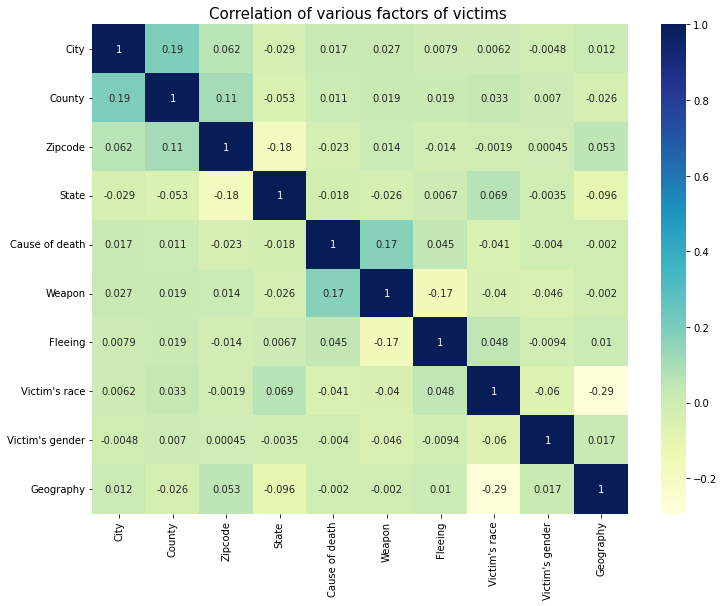

In [19]:
#@title 3-7 Correlation heatmap for other elements on police violence
race_police_data = pd.DataFrame(df,columns=["City","County","Zipcode","State","Cause of death","Weapon","Fleeing","Victim's race","Victim's gender","Geography"])
race_police_data

race_code = race_police_data.copy()
le = OrdinalEncoder()
le.fit(race_code[["City","County","Zipcode","State","Cause of death","Weapon","Fleeing","Victim's race","Victim's gender","Geography"]])
race_code[["City","County","Zipcode","State","Cause of death","Weapon","Fleeing","Victim's race","Victim's gender","Geography"]] = le.transform(race_code[["City","County","Zipcode","State","Cause of death","Weapon","Fleeing","Victim's race","Victim's gender","Geography"]])
race_code.corr()

plt.subplots(figsize=(12,9))
sns.heatmap(race_code.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation of various factors of victims ',fontsize = 15)
plt.show()

#####Analytical Conclusion:
- Through the correlation analysis of some elements in the table, we found that the correlation of each element is very low or even non-existent. This data shows that the police's violent law enforcement may not be treated very significantly differently because of the geographical location of the incident, the age of the victim, and the race.


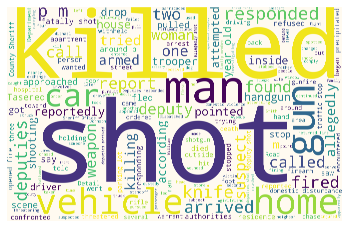

In [20]:
#@title 3-8 Word cloud of case details description 

df_WC = pd.DataFrame(df,columns=["Description"])
df_WC["Description"].to_csv('police_description_texts.txt', sep='\t', index=False)

stopwords = STOPWORDS.copy()

stopwords.add('police')
stopwords.add('officer')
stopwords.add('officers')
stopwords.add('said')

f = open(r"police_description_texts.txt",'r',encoding='utf-8').read()

wordcloud = WordCloud(
        background_color="FloralWhite",
        max_words=200,
        width= 3000,           
        height= 1920,
        stopwords = stopwords,
        scale = 5).generate(f)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#####Analytical Conclusion:
 - Through word cloud map generation, we can learn the most frequently mentioned keywords in the case introduction, such as killed, shot, home, etc.
 - At the same time, the most mentioned characters are men, and the most mentioned weapons are gun, knife, etc.
 - Word cloud shows the objective law of the case content

##4.A More Detailed and Systematic Exploration of Racial Issues of Hot Spot
In this section, we will try to present a more detailed discovery of hot spot of American police fatalities issues: racial. Is colored people more likely to be manslaughtered by American police?

In [21]:
#@title 4-1 Racial Distribution of Police Manslaughter Victims Compared to Racial Distribution of Total Victims
ob_count = df.groupby(by="Victim's race")['City'].count().to_frame().reset_index()
ob2_count = ob2.groupby(by="Victim's race")['City'].count().to_frame().reset_index()
names = ["Victim's race","Count"]
ob_count.columns = names
ob2_count.columns = names

piecolors=['rgb(255,0,0)','rgb(255,204,51)']
figpie = make_subplots(rows=1,cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]],subplot_titles=['Race of all victims', 'Race of killed by manslaughter'])
figpie.add_trace(go.Pie(labels=ob_count["Victim's race"],values=ob_count['Count'],marker_colors=piecolors,name="Victim's race",pull=[0, 0, 0, 0,0,0,0.2]),1,1)
figpie.add_trace(go.Pie(labels=ob2_count["Victim's race"],values=ob2_count['Count'],marker_colors=piecolors,name="Victim's race",pull=[0, 0.2, 0, 0]),1,2)

#####Analytical Conclusion:
 - Contrast the racial distribution of the number of police manslaughters with the racial distribution of the total victims, shown in a pie chart.
 - In the racial distribution of all victims, the number of white deaths was the highest, reaching 3708, accounting for 44% of the total number, while the number of black victims was 2121, only half of the white victims.
 - In the racial distribution of police manslaughter victims, the most numerous race is black, with 52 fatalities, but the number of whites killed by manslaughter is almost the same at 51, and the death tolls of the two races Accounted for 66% of the total number of people who were killed by manslaughter.
 - All in all, the total number of police deaths in the United States does not have a clear racial color in everyone's impression. On the contrary, it is what we think of as a strong white race that accounts for a very large part of the death toll; Blacks have the most deaths, but there is only one difference between the number of deaths and whites. From the available data, we cannot determine that there is a strong correlation between police killings in the United States and the race of the victims, on the very contract of the long-term global media image of American law enforcement system.

##Total Conclusion
Based on the database we are currently using, the research results are as follows:
 - From an overall perspective, in almost all years, regardless of the dimensions of age, gender, race, etc., the overall results of the numbers and proportion of victims do not seem to be calling for any special attention. The performance of American domestic law enforcement is **basically in a steady state**, without any tendency to change direction on the surface.
 - The vast majority of police fatalities involved victims showing violence or attempt to strike back. The overall manslaughter rate accounted for about 1.82% of the total. The specific value is shocking and worthy of vigilance by US domestic law enforcement agencies, but it does not reflect any deeper and broader harm; furthermore, analysis from our database did not find any strong evidence enough to support the claim that victims of certain natural characteristics or races suffer more from police manslaughter harm.

In conclusion, based on the dataset we used, it is difficult to support the current popular stereotypes of 'brutal and biased American police department'.